# Biotuner Paper Examples

In [3]:
from biotuner.biotuner_object import *
from biotuner.metrics import *
import pandas as pd
import seaborn as sns

### Figure 2. Performance analysis of different peak extraction methods

fixed


harmonic_recurrence
EIMC
EMD
FOOOF


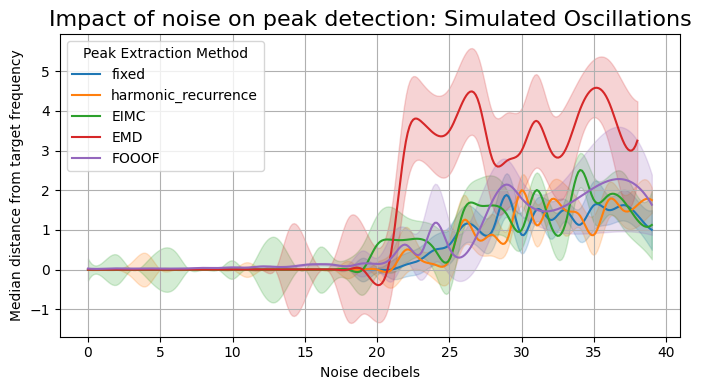

fixed
harmonic_recurrence
EIMC
EMD
FOOOF


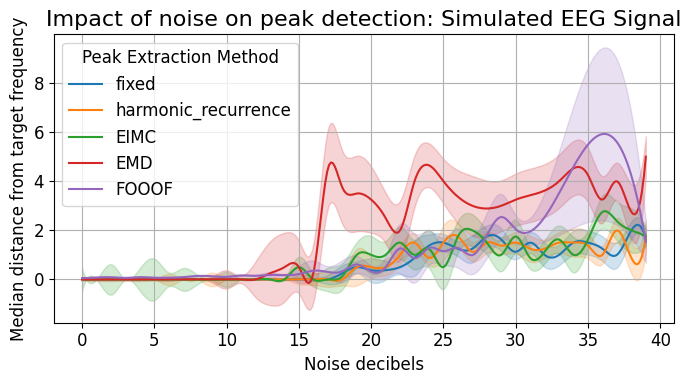

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined
from scipy.interpolate import make_interp_spline, BSpline
from biotuner.biotuner_utils import generate_signal
from biotuner.biotuner_object import compute_biotuner
import numpy as np


# Setting up parameters
sf = 1000
length = 4
n_times = 10 #number of times the bootstraping is executed
freqs = [2, 6, 12, 24]
amps = [1, 1, 1, 1]
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]

# Simulate the signals
components = {
    'sim_powerlaw': {'exponent': -1}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs]  # list of dictionaries
}
component_variances = [1 for _ in range(len(freqs) + 1)]  # +1 for the 'sim_powerlaw' component

# Simulate original signal
simulated_EEG = sim_combined(length, sf, components, component_variances)

# Simulate EEG signal
simulated_oscillations = generate_signal(sf, length, freqs, amps, show=False, color = 'turquoise')  # Assuming generate_signal is your custom function

signals = {'Simulated Oscillations': simulated_oscillations, 'Simulated EEG Signal': simulated_EEG}

for title, signal in signals.items():
    peaks_methods = ['fixed', 'harmonic_recurrence', 'EIMC', 'EMD', 'FOOOF']
    noise_db_list = range(0, 40, 1)
    colors = ['darkred', 'darkblue', 'darkorange', 'black', 'cyan', 'deeppink']

    data = []
    for method, color in zip(peaks_methods, colors):
        print(method)
        median_distance_tot = []
        for db in noise_db_list: 
            t = 0
            median_distance = []
            while t < n_times:
                # Convert to linear Watt units
                target_noise_watts = 10 ** (db / 10)

                # Generate noise samples
                mean_noise = 0
                noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))
                # transform noise into pink noise
                

                # Noise up the original signal with pink noise
                noised_signal = signal + noise_signal
            
                # set dictionary of prominence and rel_height for each method
                prominences = {'fixed': 10, 'harmonic_recurrence': 6, 'EMD': 1, 'FOOOF': 10, 'HH1D_max': 1, 'EIMC': 7}
                rel_heights = {'fixed': 1, 'harmonic_recurrence': 1, 'EMD': 0.7, 'FOOOF': 1, 'HH1D_max': 1, 'EIMC': 1}
                # Initialize biotuner object
                biotuning = compute_biotuner(sf = sf, peaks_function=method, precision=0.5)
                
                if method == 'EMD_fast':
                    biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                        FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                        rel_height=rel_heights[method], nIMFs=6, keep_first_IMF=False, n_peaks=6)
                    biotuning.peaks = biotuning.peaks[0:4] # select only the first 4 peaks
                    biotuning.peak = [x for x in biotuning.peaks if x <= freqs[-1]+1]
                    
                else:
                    
                    biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                        FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                        rel_height=rel_heights[method], nIMFs=3, keep_first_IMF=True, n_peaks=4)
                    biotuning.peaks = [x for x in biotuning.peaks if x <= freqs[-1]+1]

                if db == 0:
                    no_noise_peaks = biotuning.peaks
                if len(biotuning.peaks) == 0:
                    median_distance.append(np.nan)
                else:
                    list_distance = []
                    for p in biotuning.peaks:
                        takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
                        closest = takeClosest(p,freqs)
                        list_distance.append(abs(p-closest))   
                    median_distance.append(np.nanmedian(list_distance))
                t += 1
            median_distance_tot.append(np.nanmedian(median_distance)) 
            # calculate standard deviation
            std_dev = np.std(median_distance)
                    # Continue with your computations... 

            data.append([method, db, np.nanmedian(median_distance), np.std(median_distance)])

    df = pd.DataFrame(data, columns=["Method", "Noise decibels", "Median distance", "Std deviation"])

    # Add the option for std or 95% CI
    error_option = 'CI'  # change to 'std' for standard deviation

    plt.figure(figsize=(7,4))
    for method in peaks_methods:
        df_method = df[df["Method"] == method]
        df_method = df_method[df_method['Std deviation'].notna()]
        
        # To create smooth line plot
        xnew = np.linspace(df_method["Noise decibels"].min(), df_method["Noise decibels"].max(), 300)
        spl = make_interp_spline(df_method["Noise decibels"], df_method["Median distance"], k=3)  # type: BSpline
        y_smooth = spl(xnew)
        
        if error_option == 'std':
            spl_std = make_interp_spline(df_method["Noise decibels"], df_method["Std deviation"], k=3)  # type: BSpline
            error_smooth = spl_std(xnew)
        elif error_option == 'CI':
            confidence_interval = df_method["Std deviation"] / np.sqrt(n_times) * 1.96
            spl_ci = make_interp_spline(df_method["Noise decibels"], confidence_interval, k=3)  # type: BSpline
            error_smooth = spl_ci(xnew)

        line, = plt.plot(xnew, y_smooth, label=method)  # use same color for the line
        color = line.get_color()  # get color of the line

        plt.fill_between(xnew, y_smooth-error_smooth, y_smooth+error_smooth, color=color, alpha=0.2)

    plt.title(f'Impact of noise on peak detection: {title}', size=16)
    plt.grid(True)
    plt.legend(loc="upper left", title="Peak Extraction Method")
    plt.xlabel("Noise decibels")
    plt.ylabel("Median distance from target frequency")
    plt.tight_layout()
    # increase all fonts
    plt.rc('font', size=12)
    plt.savefig(f'b100_nonharm_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

### Figure 3. Comparative analysis of harmonicity metrics from unison to octave. 

In [5]:
# Generate all pairs of values with 0.1 precision between 1 and 10
values = np.arange(5, 10.1, 0.1)
pairs = [(round(x, 1), round(y, 1)) for x in values for y in values if x != y]
cons_tot = []
tenney_tot = []
harmsim_tot = []
subharm_tension_tot = []
subharm_tension2_tot = []
euler_tot = []
int_tenney_tot = []
for peaks in pairs:
    peaks = list(peaks)
    peaks_ratios = compute_peak_ratios(
            peaks, rebound=True, octave=2, sub=False
        )
    a, b, c, cons = consonance_peaks(peaks, 0.1)
    tenney = tenneyHeight(peaks)
    int_tenney = integral_tenneyHeight(peaks)
    harmsim = np.average(ratios2harmsim(peaks_ratios))
    _, _, subharm, _ = compute_subharmonic_tension(peaks,
                                                       5,
                                                       50,
                                                       min_notes=2)
    _, _, subharm2, _ = compute_subharmonic_tension(peaks,
                                                        20,
                                                        50,
                                                        min_notes=2)
    subharm_tension = subharm[0]
    peaks_euler = [int(round(num, 2) * 1000) for num in peaks]
    euler_ = euler(*peaks_euler)
    cons_tot.append(cons)
    tenney_tot.append(tenney)
    harmsim_tot.append(harmsim)
    subharm_tension_tot.append(subharm_tension)
    subharm_tension2_tot.append(subharm2[0])
    int_tenney_tot.append(int_tenney)
    #print('SUBHARM TENSION: ', subharm2[0])
    euler_tot.append(euler_)
    
# create a dataframe with all the values
df = pd.DataFrame({'cons': cons_tot,
                   'tenney': tenney_tot,
                   'int_tenney': int_tenney_tot, # 'int_tenney': int_tenney_tot,
                   'harmsim': harmsim_tot,
                   'subharm_tension': subharm_tension_tot,
                   'subharm_tension2': subharm_tension2_tot,
                   'euler': euler_tot,
                   'freq_pairs': pairs})

c:\users\user\github\biotuner\biotuner\metrics.py:744: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1 / delta_norm)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


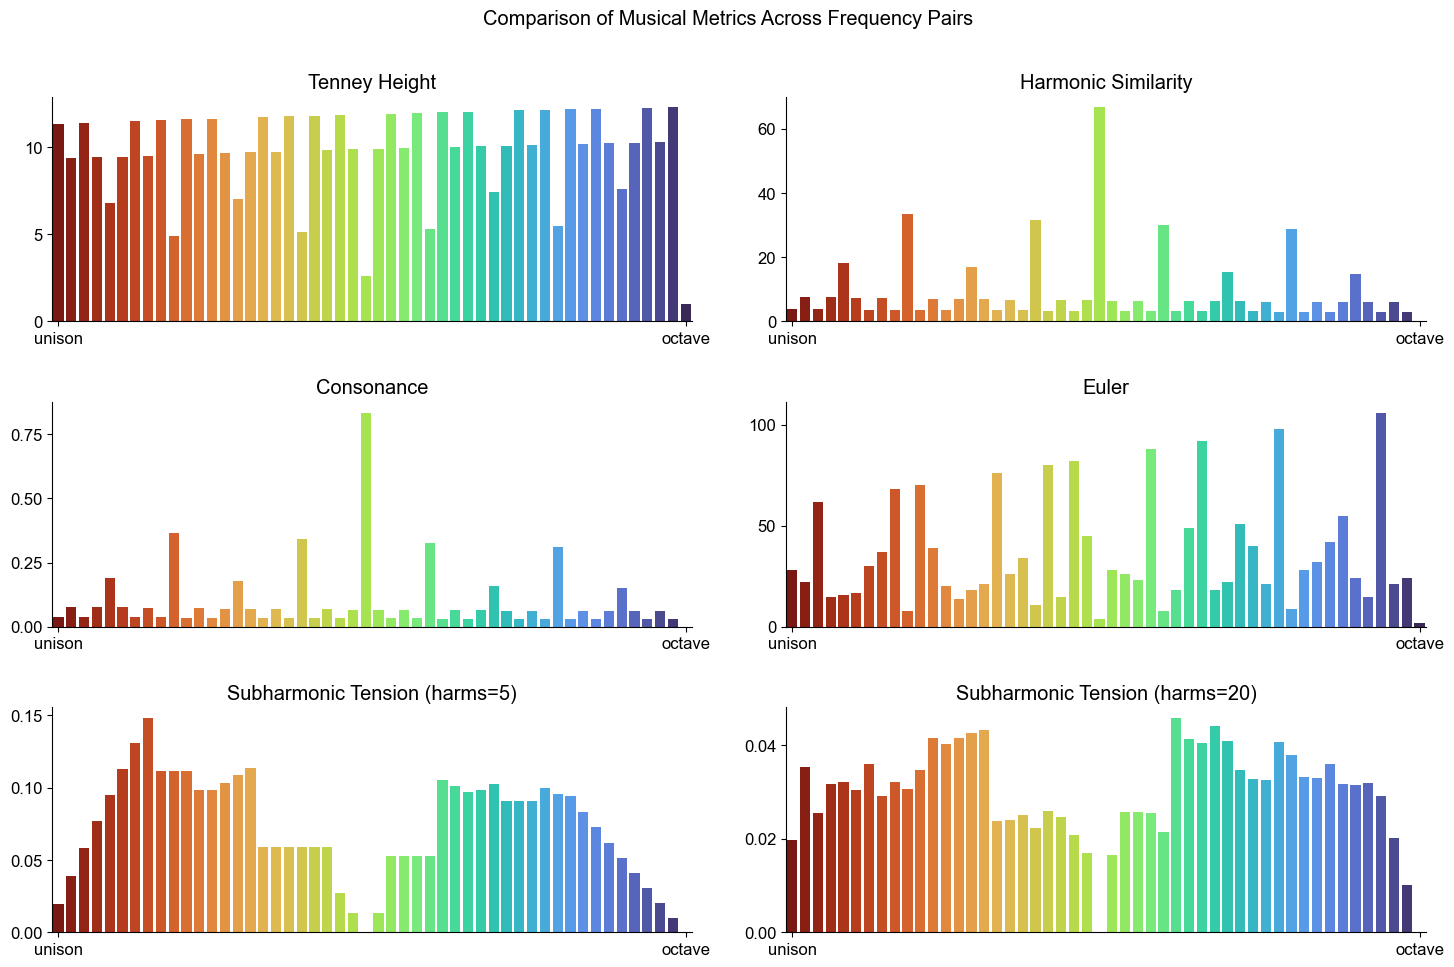

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'data' is a DataFrame with columns: 'Frequency Pair', 'Tenney Height', 'Harmonic Similarity', 'Consonance', 'Euler'
data = df.copy()
# take 100 first pairs
data = data[:50]
fig, axs = plt.subplots(3, 2, figsize=(15, 10))  # Adjust size as needed
fig.suptitle('Comparison of Musical Metrics Across Frequency Pairs')
# set cmap
cmap = ['RdBu_r', 'coolwarm', 'bwr', 'seismic']
cmap = 'turbo_r'
# Plotting each metric in a separate subplot
sns.barplot(x='freq_pairs', y='tenney', data=data, ax=axs[0, 0], palette=cmap)
axs[0, 0].set_title('Tenney Height')

sns.barplot(x='freq_pairs', y='harmsim', data=data, ax=axs[0, 1],palette=cmap)
axs[0, 1].set_title('Harmonic Similarity')

sns.barplot(x='freq_pairs', y='cons', data=data, ax=axs[1, 0], palette=cmap)
axs[1, 0].set_title('Consonance')

sns.barplot(x='freq_pairs', y='euler', data=data, ax=axs[1, 1], palette=cmap)
axs[1, 1].set_title('Euler')

sns.barplot(x='freq_pairs', y='subharm_tension', data=data, ax=axs[2, 0], palette=cmap)
axs[2, 0].set_title('Subharmonic Tension (harms=5)')

sns.barplot(x='freq_pairs', y='subharm_tension2', data=data, ax=axs[2, 1], palette=cmap)
axs[2, 1].set_title('Subharmonic Tension (harms=20)')

# Formatting


for ax in axs.flat:
    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=0)  # Rotate x-axis labels for readability
    # remove x-axis labels
    ax.set_xticklabels([])
    # write 'unison' as the first label and 'octave' as the last label
    ax.set_xticks([0, 49])
    ax.set_xticklabels(['unison', 'octave'])
    # make the plot style nicer
    sns.set_style("white")
    sns.despine()
    
# change font size
sns.set(font_scale=1.8)
# white background
sns.set_style("white")
plt.tight_layout()
# save figure
plt.savefig('metrics_comparison2.png', dpi=300)

plt.show()


### Figure 4. Correlation Matrix for sets of 2 peaks

C:\Users\User\AppData\Local\Temp\ipykernel_10072\3753942918.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Figure size 640x480 with 0 Axes>

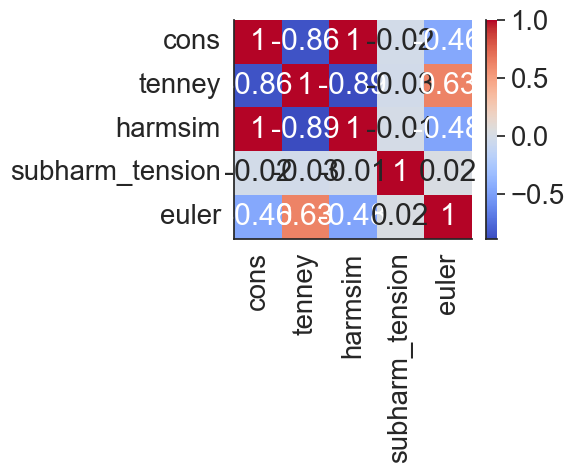

In [ ]:
# print correlation matrix using seaborn
import seaborn as sns
# clear the figure
plt.clf()
# list symetric cmap
cmap = ['RdBu_r', 'coolwarm', 'bwr', 'seismic']
corr = df.corr()
# round the values
corr = corr.round(2)
# remove int_tenney and subharm_tension2
corr = corr.drop(['int_tenney', 'subharm_tension2'], axis=1)
corr = corr.drop(['int_tenney', 'subharm_tension2'], axis=0)
# set figsize
plt.figure(figsize=(6, 5))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, cmap='coolwarm')
# make text bigger
sns.set(font_scale=1.3)

# make the plot style nicer
sns.set_style("whitegrid")
sns.despine()
plt.tight_layout()
plt.savefig('correlation_matrix_pairs.png', dpi=300)
plt.show()

### Figure 4. Correlation Matrix for sets of 3 peaks

In [8]:
import random
# Generate all triplets of values with 0.1 precision between 1 and 10
values = np.arange(1, 10.1, 0.1)
triplets = [(round(x, 1), round(y, 1), round(z, 1)) for x in values for y in values for z in values if x != y and y != z and x != z]
# select 8190 triplets randomly
triplets = random.sample(triplets, 8190)
cons_tot = []
tenney_tot = []
harmsim_tot = []
subharm_tension_tot = []
euler_tot = []
for peaks in triplets:
    peaks = list(peaks)
    peaks_ratios = compute_peak_ratios(
            peaks, rebound=True, octave=2, sub=False
        )
    a, b, c, cons = consonance_peaks(peaks, 0.1)
    tenney = tenneyHeight(peaks)
    harmsim = np.average(ratios2harmsim(peaks_ratios))
    _, _, subharm, _ = compute_subharmonic_tension(peaks,
                                                       10,
                                                       200,
                                                       min_notes=2)
    subharm_tension = subharm[0]
    peaks_euler = [int(round(num, 2) * 1000) for num in peaks]
    euler_ = euler(*peaks_euler)
    cons_tot.append(cons)
    tenney_tot.append(tenney)
    harmsim_tot.append(harmsim)
    subharm_tension_tot.append(subharm_tension)
    euler_tot.append(euler_)
    
# create a dataframe with all the values
df2 = pd.DataFrame({'cons': cons_tot,
                   'tenney': tenney_tot,
                   'harmsim': harmsim_tot,
                   'subharm_tension': subharm_tension_tot,
                   'euler': euler_tot})

c:\users\user\github\biotuner\biotuner\metrics.py:744: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1 / delta_norm)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


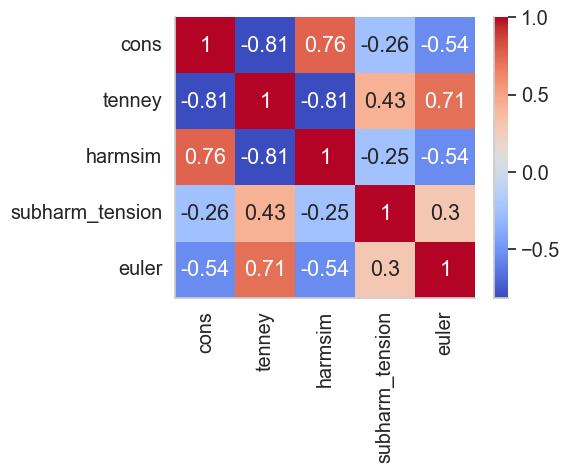

In [9]:
# print correlation matrix using seaborn
import seaborn as sns
# list symetric cmap
cmap = ['RdBu_r', 'coolwarm', 'bwr', 'seismic']
corr = df2.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, cmap='coolwarm')
# make text bigger
sns.set(font_scale=1.3)

# make the plot style nicer
sns.set_style("whitegrid")
plt.tight_layout()
sns.despine()
plt.savefig('correlation_matrix_triplets.png', dpi=300)
plt.show()

### Figure 5. Time-Resolved Harmonicity using instantaneous frequencies for three different types of signals

(4, 1800)
(4, 1800)
(4, 1800)
Dyad similarity:  (3, 1800)


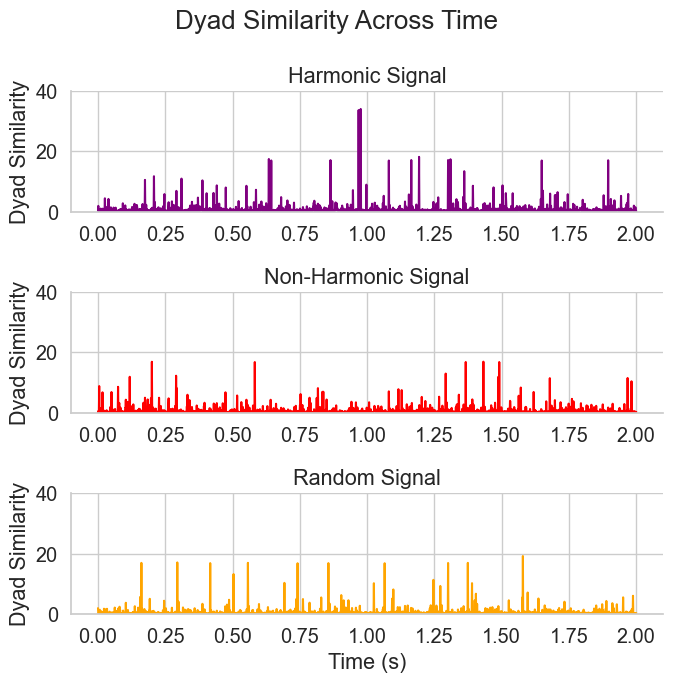

In [10]:
from biotuner.biotuner_object import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from PyEMD import EMD
from fractions import Fraction
from biotuner.metrics import dyad_similarity
import seaborn as sns

def simulate_harmonic_signal(frequencies, amplitudes, duration, sampling_rate):
    time = np.linspace(0, duration, int(sampling_rate * duration))
    signal = np.sum([amp * np.sin(2 * np.pi * freq * time) for freq, amp in zip(frequencies, amplitudes)], axis=0)
    return time, signal

# Simulate a signal
sampling_rate = 1000  # in Hz
duration = 2  # in seconds
frequencies = [10, 15, 20]  # in Hz
amplitudes = [1, 0.5, 0.2]

time, signal = simulate_harmonic_signal(frequencies, amplitudes, duration, sampling_rate)

time, signal2 = simulate_harmonic_signal([10, 15.7, 21.9], [1, 0.5, 0.2], duration, sampling_rate)


# create random signal
signal3 = np.random.rand(len(time))

signals = [signal, signal2, signal3]

dyad_sim_tot = []
dyad_sim_tot = []
IFs = []
chords_all = []
chords_pos_all = []
for sig in signals:
    bt = compute_biotuner(data=sig, sf=sampling_rate, peaks_function='EMD_fast')
    tr_harm, chords, chords_pos = bt.time_resolved_harmonicity(nIMFs=3, input='SpectralCentroid', window=50, keep_first_IMF=True, graph=False, limit_cons=15, min_notes=3)
    IFs.append(bt.spectro_EMD)
    chords_all.append(chords)
    chords_pos_all.append(chords_pos)
    dyad_sim_tot.append(tr_harm)


print('Dyad similarity: ', np.array(dyad_sim_tot).shape)
colors = ['purple', 'red', 'orange']
# create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(7, 7))  # Adjust size as needed
fig.suptitle('Dyad Similarity Across Time')
# set white background
sns.set_style("white")
# use dyad_sim_tot to derive time
time = np.linspace(0, duration, len(dyad_sim_tot[0]))
# Plotting each metric in a separate subplot
axs[0].plot(time, dyad_sim_tot[0], color=colors[0])
axs[0].set_title('Harmonic Signal')
axs[1].plot(time, dyad_sim_tot[1], color=colors[1])
axs[1].set_title('Non-Harmonic Signal')
axs[2].plot(time, dyad_sim_tot[2], color=colors[2])
axs[2].set_title('Random Signal')
#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
#axs[2].set_yscale('log')
# Formatting
for ax in axs.flat:
    # remove xlabel
    ax.set_ylabel('Dyad Similarity')
    ax.tick_params(axis='x')  # Rotate x-axis labels for readability
    # set ylim to 0-35
    ax.set_ylim([0, 40])
    # make the plot style nicer
    sns.set_style("whitegrid")
    sns.despine()
    # log y-axis
# set x-axis title only for the last subplot
axs[2].set_xlabel('Time (s)')
    

plt.tight_layout()
plt.show()
#plt.savefig('time_resolved_example_centroid.png', dpi=300)

### Figure 6. Identification of spectral chords using time-resolved harmonicity

<Figure size 640x480 with 0 Axes>

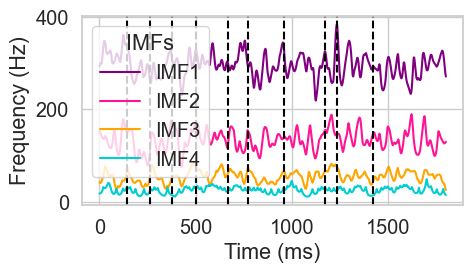

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming IFs, chords_pos_all, and chords_all are defined elsewhere in your code

final_IFs = IFs[-1]
final_chord_pos = chords_pos_all[-1]
final_chords = chords_all[-1]

# plot final IFs with seaborn lineplot
sns.set_style("whitegrid")
sns.despine()
plt.figure(figsize=(5, 3))

# Swap axes
final_IFs = final_IFs.T

# Define colors
colors = ['purple', 'deeppink', 'orange', 'darkturquoise']

# Create line plot with different colors for each line but same linestyle
ax = sns.lineplot(data=final_IFs, dashes=False, palette=colors, linewidth=1.5)

# Set axis labels
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

# Add vertical lines for chord positions (which are indexes of the IFs)
for pos in final_chord_pos:
    plt.axvline(x=pos, color='black', linestyle='--')

# Get the lines from the axes to create custom handles for the legend
lines = ax.get_lines()

# Create custom handles for the legend
custom_handles = [lines[i] for i in range(4)]

# Create custom labels for the legend
custom_labels = ['IMF1', 'IMF2', 'IMF3', 'IMF4']

# Set the legend with custom handles and labels
plt.legend(handles=custom_handles, labels=custom_labels, title='IMFs', loc='upper left')

plt.tight_layout()
#plt.savefig('spectro_EMD_example.png', dpi=300)
plt.show()


In [12]:
import numpy as np

# Frequency to note mapping
A4 = 440
C0 = A4 * np.power(2, -4.75)
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def freq_to_note(frequency):
    """ Convert a frequency to a musical note name. """
    h = round(12 * np.log2(frequency / C0))
    octave = h // 12
    n = h % 12
    return note_names[n] + str(octave)

# Your sets of frequencies
freq_sets = final_chords
# shift all freqs by factor 4
freq_sets = [[x*8 for x in freq] for freq in freq_sets]

# Convert each set of frequencies to notes
chords = []
for freq_set in freq_sets:
    chord = [freq_to_note(f) for f in freq_set]
    chords.append(chord)

print("Chords (in note names):")
for i, chord in enumerate(chords):
    print(f"Chord {i + 1}: {', '.join(chord)}")


# convert note from Hz to MIDI
def freq_to_midi(frequency):
    """ Convert a frequency to a MIDI note number. """
    return 69 + 12 * np.log2(frequency / A4)

# Your sets of frequencies
MIDI_set = []
for freq_set in freq_sets:
    MIDI_set.append([freq_to_midi(f) for f in freq_set])
    
# generate a simple MIDI file with the chords
from mido import Message, MidiFile, MidiTrack

mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

# Add a track name and tempo. The first argument to Message is the MIDI event type, and the remaining arguments are data.
track.append(Message('program_change', program=12, time=0))

# Add notes. The first argument is the MIDI note number, and the second argument is the note duration in beats.
for chord in MIDI_set:
    for note in chord:
        track.append(Message('note_on', note=int(note), velocity=100, time=0))
    for note in chord:
        track.append(Message('note_off', note=int(note), velocity=100, time=100))
        
# Save the MIDI file
mid.save('example.mid')

Chords (in note names):
Chord 1: C4, D5, D6, E7
Chord 2: A#3, C5, C6, C7
Chord 3: A#2, G#4, F6, D#7
Chord 4: A#3, D#5, F6, E7
Chord 5: F#3, B4, B5, D7
Chord 6: G3, D5, D#6, D7
Chord 7: A3, C5, C#6, E7
Chord 8: B3, C5, D#6, E7
Chord 9: G3, D5, D6, F#7
Chord 10: A2, E4, D6, D7


### Figure 7. Comparison of Normalized Dissonance and Harmonic Entropy Across Different Sets of Harmonics. 

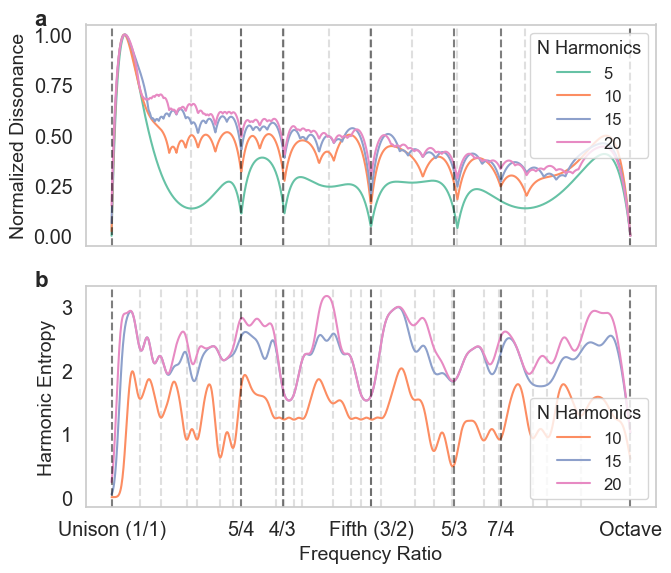

In [13]:
# Assuming the functions diss_curve and harmonic_entropy are pre-defined and accessible
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from biotuner.scale_construction import diss_curve, harmonic_entropy
from biotuner.biotuner_utils import compute_peak_ratios, ratios_increments
from biotuner.peaks_extension import harmonic_fit
from biotuner.vizs import plot_diss_curve, plot_harm_entropy
from scipy.signal import argrelextrema
from fractions import Fraction
# Set the style of seaborn
sns.set_style("whitegrid")

peaks_dict = {
    '5': [1, 2, 3, 4, 5],
    '10': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    '15': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15],
    '20': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16, 17, 18, 19, 20],
}
# Create subplots with shared x-axis
fig, axs = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
colors = sns.color_palette("Set2", n_colors=len(peaks_dict.keys()))
# Plotting the dissonance curves for each dictionary
plot_diss_curve(peaks_dict, colors=colors, ax = axs[0])
HE_scale = plot_harm_entropy(peaks_dict, colors=colors, ax=axs[1])
# add letter a and b to the subplots
axs[0].text(-0.09, 1.07, 'a', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top')
axs[1].text(-0.09, 1.07, 'b', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top')

axs[-1].set_xlabel('Frequency Ratio', fontsize=14)
# replace xticks with ratios names
ticks = [1, 1.25, 1.33, 1.5, 1.66, 1.75, 2]
axs[-1].set_xticks(ticks)
# add black vertical lines for the ratios
for ratio in ticks:
    axs[0].axvline(ratio, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    axs[1].axvline(ratio, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axs[-1].set_xticklabels(['Unison (1/1)', '5/4','4/3', 'Fifth (3/2)', '5/3', '7/4', 'Octave'])
# remove horizontal grid lines only
axs[0].grid(axis='y')
axs[1].grid(axis='y')
# remove vertical grid lines
axs[0].grid(axis='x')
axs[1].grid(axis='x')


plt.tight_layout()
#plt.savefig('dissonance_curves_harmonic_entropyX.png', dpi=300)
plt.show()

### Figure 8. Visualization of Euclidean rhythms with varying maximal denominators

c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 2000 is greater than input length  = 800, using nperseg = 800
  warnings.warn('nperseg = {0:d} is greater than input length '


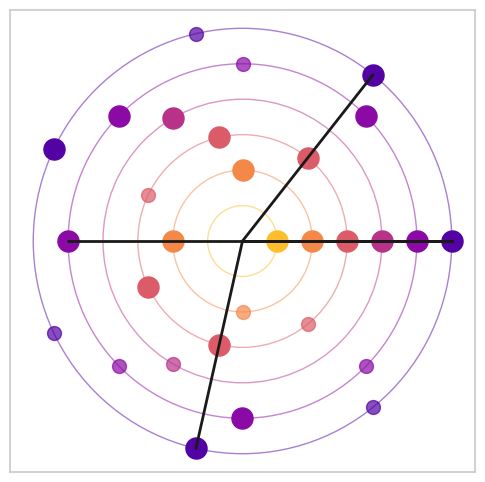

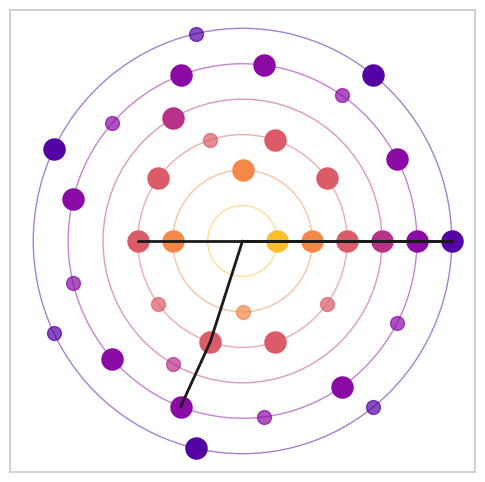

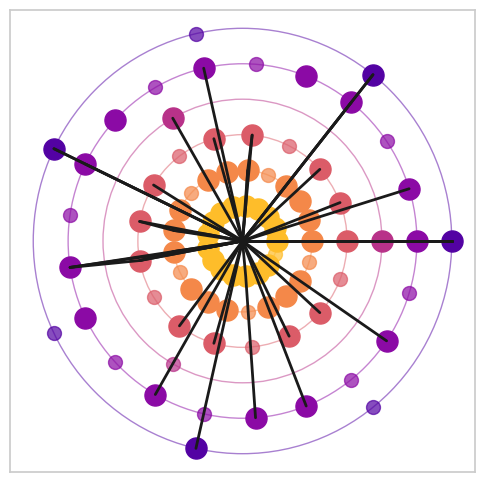

In [14]:
from biotuner.biotuner_object import *


max_denoms = [6, 8, 16]
# create three empty subplots without showing them
#fig, axs = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
# create signal with harmonics 10, 20 and 30 Hz
time = np.linspace(0, 1, 800)
signal = np.sum([1 * np.sin(2 * np.pi * freq * time) for freq in [10, 13.33, 15, 20, 26.66, 30, 40]], axis=0)
# add noise
#signal += np.random.normal(0, 0.2, len(time))
for max_denom in max_denoms:
    # Create a BioTuner object
    bt = compute_biotuner(sf=1000, peaks_function='EMD')
    bt.peaks_extraction(data=signal, precision=0.5, graph=False, min_freq=9, max_freq=41, prominence=1, identify_labels=True, n_peaks=5)
    a, b, c = bt.rhythm_construction(mode='default', graph=True, scale='peaks_ratios', optimal_offsets=False, max_denom=max_denom)
    


### Figure 9a. Transitional Harmony in I-IV-V-I progression

c:\users\user\github\biotuner\biotuner\metrics.py:845: RuntimeWarning: divide by zero encountered in double_scalars
  harm_temp.append(1/delta_norm)


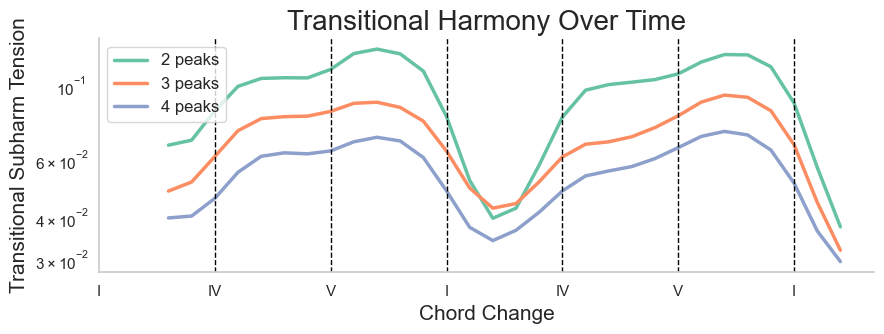

In [15]:
from biotuner.transitional_harmony import transitional_harmony
from biotuner.dictionaries import chord_frequencies
progressions = {
    'I-IV-V Progression': ['C', 'F', 'G', 'C', 'F', 'G', 'C']
}
precision=1
# Helper function to generate the signal for each chord progression
def generate_signal_for_progression(chord_sequence, chord_freqs, duration_per_chord=1, sampling_rate=10000):
    signal_length = duration_per_chord * len(chord_sequence) * sampling_rate
    time = np.linspace(0, duration_per_chord * len(chord_sequence), signal_length)
    signal = np.zeros_like(time)

    for i, chord in enumerate(chord_sequence):
        start = i * duration_per_chord * sampling_rate
        end = (i + 1) * duration_per_chord * sampling_rate
        for freq in chord_freqs[chord]:
            signal[start:end] += np.sin(2 * np.pi * freq * time[start:end])

    return signal, time

overlap=80
tharm=15
# Generate signals for each progression
sig_, time_ = generate_signal_for_progression(progressions['I-IV-V Progression'], chord_frequencies)

th = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=2)
th_1, time_vec_final, subharm_melody = th.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

th2 = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=3)
th2_1, time_vec_final, subharm_melody = th2.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

th3 = transitional_harmony(sf=10000, data=sig_, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=tharm, max_freq=1000, max_harm_freq=20000,
                        FREQ_BANDS=None, n_peaks=4)

th3_1, time_vec_final, subharm_melody = th3.compute_trans_harmony(overlap=overlap, mode='win_overlap', delta_lim=5)

from scipy.ndimage import gaussian_filter1d

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(9, 3.5))

# Generate two separate color palettes for H10 and H5
colors_h10 = sns.color_palette("Set2", n_colors=3)  # Degradé for H10
colors_h5 = sns.color_palette("Oranges_r", n_colors=5)  # Degradé for H5

# Plot the transitional harmony vectors for H15
for i, trans_subharm in enumerate([th_1, th2_1, th3_1]):
    sigma = 1.  # Smoothing parameter
    y_smooth = gaussian_filter1d(trans_subharm, sigma=sigma)
    plt.plot(time_vec_final, y_smooth, linewidth=2.5, color=colors_h10[i], label=f'{i+2} peaks')


# Customization of the plot
plt.xlabel('Chord Change', fontsize=15)
plt.ylabel('Transitional Subharm Tension', fontsize=15)
plt.title('Transitional Harmony Over Time', fontsize=20)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['I', 'IV', 'V', 'I', 'IV', 'V', 'I'])

plt.legend(loc='upper left', fontsize=12)

# add vertical dashed black lines for chord changes
for i in range(1, 7):
    chord_change_time = i * 1
    plt.axvline(x=chord_change_time, color='black', linestyle='--', linewidth=1)
# log y-scale
plt.yscale('log')
sns.despine()  # Remove top and right borders
sns.set(font_scale=1)  # Set font scale
plt.grid(False)  # Remove grid
plt.tight_layout()  # Ensure everything fits without overlapping

# Save and show the figure
#plt.savefig('transitional_harmony_I_IV_V_I.png', dpi=300)
plt.show()

### Figure 9b. Smoothed transitional harmony for ecg simulated signals

C:\Users\User\AppData\Local\Temp\ipykernel_10072\926778720.py:39: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2_r')


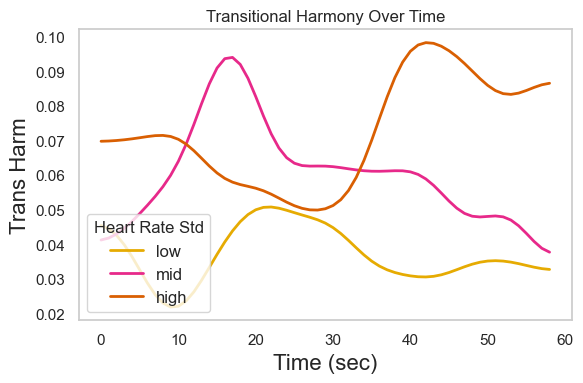

In [16]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from biotuner.transitional_harmony import transitional_harmony

# Parameters
sampling_rate = 1000
duration = 60
heart_rate = 120
noise = 0.1
std_values = [1, 15, 30]  # Heart rate standard deviations
precision = 1

# Function to simulate ECG and apply transitional harmony
def simulate_and_compute_th(std):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    th = transitional_harmony(sf=sampling_rate, data=ecg, peaks_function='EMD', n_harm=10, precision=precision, n_trans_harm=5, 
                              min_freq=0.1, max_freq=50, max_harm_freq=2000, FREQ_BANDS=None, n_peaks=2)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=100, keep_first_IMF=False)
    return trans_subharm, ecg

# Simulate ECG data and compute transitional harmony for each standard deviation
transitional_harmonies = []
ecgs = []
for std in std_values:
    ts, ecg = simulate_and_compute_th(std)
    transitional_harmonies.append(ts)
    ecgs.append(ecg)
    

# Plotting
plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")
# Updated lines to select colors 2, 4, and 6 from Set2_r colormap
total_colors_in_set2_r = 8
color_indices = np.array([2, 4, 6]) / total_colors_in_set2_r
cmap = plt.cm.get_cmap('Dark2_r')
labels = ['low', 'mid', 'high']
# Use the updated color_indices in the plotting loop
for th, label, color in zip(transitional_harmonies, labels, cmap(color_indices)):
    th_filtered = gaussian_filter1d(th, sigma=4)
    plt.plot(th_filtered, label=label, linewidth=2, color=color)

# Customize plot
plt.legend(loc='lower left', fontsize=12, title='Heart Rate Std', title_fontsize=12)
plt.title("Transitional Harmony Over Time")
plt.xlabel("Time (sec)", fontsize=16)
plt.ylabel("Trans Harm", fontsize=16)
plt.grid(False)
plt.tight_layout()
#plt.savefig('trans_harm_heartrate_IF.png', dpi=300)
plt.show()

### Figure 9c. Distribution of transitional harmony values

Heart rate std: 1, Number of trans_subharm values stored: 2
First trans_subharm value for std 1: [0.05848468419625915, 0.05021008403361345, 0.0, 0.0, 0.0, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.0, 0.0, 0.0, 0.1004201680672269, 0.0, 0.13103520978283786, 0.0, 0.06694677871148459, 0.0, 0.05021008403361345, 0.06694677871148459, 0.06694677871148459, 0.1004201680672269, 0.029242342098129575, 0.029242342098129575, 0.029242342098129575, 0.029242342098129575, 0.0, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.05021008403361345, 0.0, 0.05021008403361345, 0.05021008403361345, 0.0, 0.027777777777777776, 0.04784688995215311, 0.05848468419625915, 0.06694677871148459, 0.037037037037037035, 0.09013417884385626, 0.08094356485198391, 0.029242342098129575, 0.06694677871148459, 0.0, 0.09865506011016847, 0.09865506011016847, 0.0, 0.05021008403361345, 0.05021008403361345, 0.0, 0.0, 0.05021008403361345, 0.06692792010811355, 0.07739279398762158

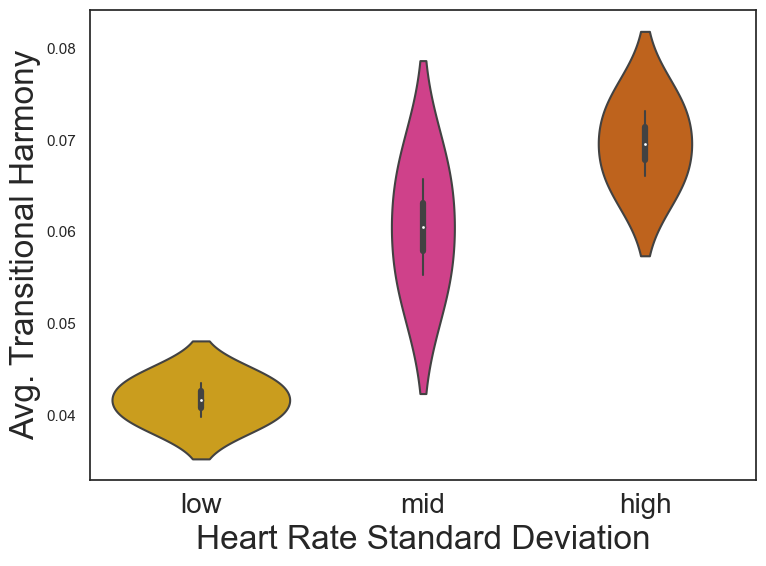

In [17]:
import neurokit2 as nk
from biotuner.transitional_harmony import transitional_harmony
import numpy as np

# Parameters
sampling_rate = 1000
duration = 60
heart_rate = 120
noise = 0.1
n_bootstraps = 2

# Standard deviations for heart rate
std_values = [1, 15, 30]

# Function to simulate ECG and compute transitional harmony
def simulate_and_compute_th(std, sampling_rate, duration, heart_rate, noise):
    ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate, heart_rate=heart_rate, heart_rate_std=std, noise=noise)
    th = transitional_harmony(sf=sampling_rate, data=ecg, peaks_function='EMD', n_harm=10, precision=1, n_trans_harm=5, min_freq=0.1, max_freq=50, max_harm_freq=2000,
                              FREQ_BANDS=None, n_peaks=2)
    trans_subharm, _, _ = th.compute_trans_harmony(overlap=0.7, mode='win_overlap', delta_lim=100, keep_first_IMF=False)
    return trans_subharm

# Bootstrapping
results = {std: [] for std in std_values}

for std in std_values:
    for _ in range(n_bootstraps):
        trans_subharm = simulate_and_compute_th(std, sampling_rate, duration, heart_rate, noise)
        results[std].append(trans_subharm)

# Displaying a summary of the results
for std, values in results.items():
    print(f"Heart rate std: {std}, Number of trans_subharm values stored: {len(values)}")
    # Example: Accessing the first trans_subharm value for each std
    print(f"First trans_subharm value for std {std}: {values[0]}")

# Prepare data for DataFrame
averaged_data = []
for std, list_of_values in results.items():
    for values in list_of_values:
        avg_value = np.mean(values)  # Calculate average of each list
        averaged_data.append({'Heart Rate Std': std, 'Average Transitional Harmony': avg_value})

# Create DataFrame
df_avg = pd.DataFrame(averaged_data)

# Create the violin plot with averaged values
plt.figure(figsize=(8, 6))
# set white background
sns.set_style("white")
sns.violinplot(x='Heart Rate Std', y='Average Transitional Harmony', data=df_avg, palette='Dark2_r')

# Customizing plot
plt.title('')
plt.xlabel('Heart Rate Standard Deviation', fontsize=24)
plt.ylabel('Avg. Transitional Harmony', fontsize=24)
# set x-ticks to 'low', 'mid', 'high'
plt.xticks(range(len(std_values)), ['low', 'mid', 'high'], fontsize=20)
# change font size
sns.set(font_scale=1.5)

plt.tight_layout()
#plt.savefig('violin_plot_trans_harm_heartrate3.png', dpi=300)
# Show plot
plt.show()


### Figure 10. Harmonic Connectivity

c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 2000, using nperseg = 2000
  warnings.warn('nperseg = {0:d} is greater than input length '


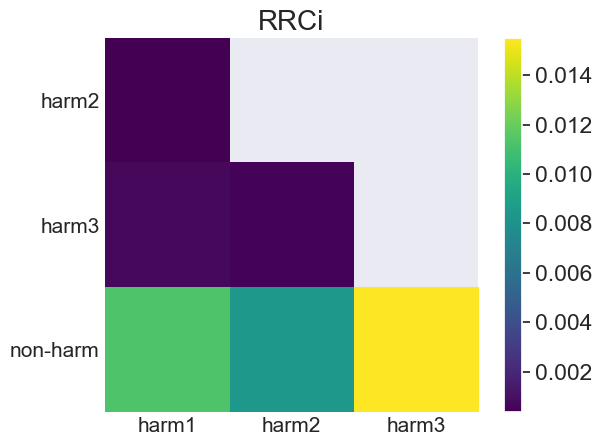

In [18]:
from biotuner.harmonic_connectivity import harmonic_connectivity

def generate_signal(freqs, time):
    # Use numpy broadcasting to generate the sum of sinusoids more efficiently
    return np.sum(np.sin(2 * np.pi * freqs[:, None] * time), axis=0)

# Generate time vector
time = np.linspace(0, 1, 2000)

# Frequencies for the signals
frequencies = [
    [20, 30, 40],
    [25, 35, 45],
    [22, 32, 42],
    [20.7, 32.4, 41.3]
]

# Generate signals using list comprehension and the generate_signal function
signals = np.array([generate_signal(np.array(freq), time) for freq in frequencies])

# Define frequency bands
FREQ_BANDS = [[15, 26], [26, 36], [36, 46]]

# Compute harmonic connectivity
hc = harmonic_connectivity(sf=1000, data=signals, min_freq=10, max_freq=50, precision=0.1, peaks_function='fixed', n_harm=10,
                           n_peaks=5)
mat_ = hc.compute_harm_connectivity(metric='RRCi', FREQ_BANDS=FREQ_BANDS, graph=False, max_denom_rrci=100, delta_lim=20,
                                    )

mat = mat_.copy()
np.fill_diagonal(mat, np.nan)
xticks = ['harm1', 'harm2', 'harm3']
yticks = ['harm2', 'harm3', 'non-harm']
# Remove upper triangle of the matrix by setting it to NaN
for i in range(len(mat)):
    for j in range(i+1, len(mat)):
        mat[i][j] = np.nan

# remove first row and last column
mat = np.delete(mat, 0, 0)
mat = np.delete(mat, -1, 1)

# Plot the matrix
fig, ax = plt.subplots()
cax = ax.matshow(mat, cmap='viridis', interpolation='nearest')

# Hide gridlines
ax.grid(False)

# Hide axes border
for edge, spine in ax.spines.items():
    spine.set_visible(False)

# Set ticks and labels
xticks = ['harm1', 'harm2', 'harm3']
yticks = ['harm2', 'harm3', 'non-harm']
ax.set_xticks(range(len(xticks)))
ax.set_yticks(range(len(yticks)))
ax.set_xticklabels(xticks, fontsize=15)
ax.set_yticklabels(yticks, fontsize=15)

ax.xaxis.set_ticks_position('bottom')

# Remove ticks
ax.tick_params(axis='both', which='both', length=0)

# Add colorbar
fig.colorbar(cax)

# Title
plt.title('RRCi', fontsize=20)

# Adjust layout
plt.tight_layout()

# Save figure
#plt.savefig('wPLI_multiband3.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Figure 11. Harmonic Spectrum

c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 2000, using nperseg = 2000
  warnings.warn('nperseg = {0:d} is greater than input length '


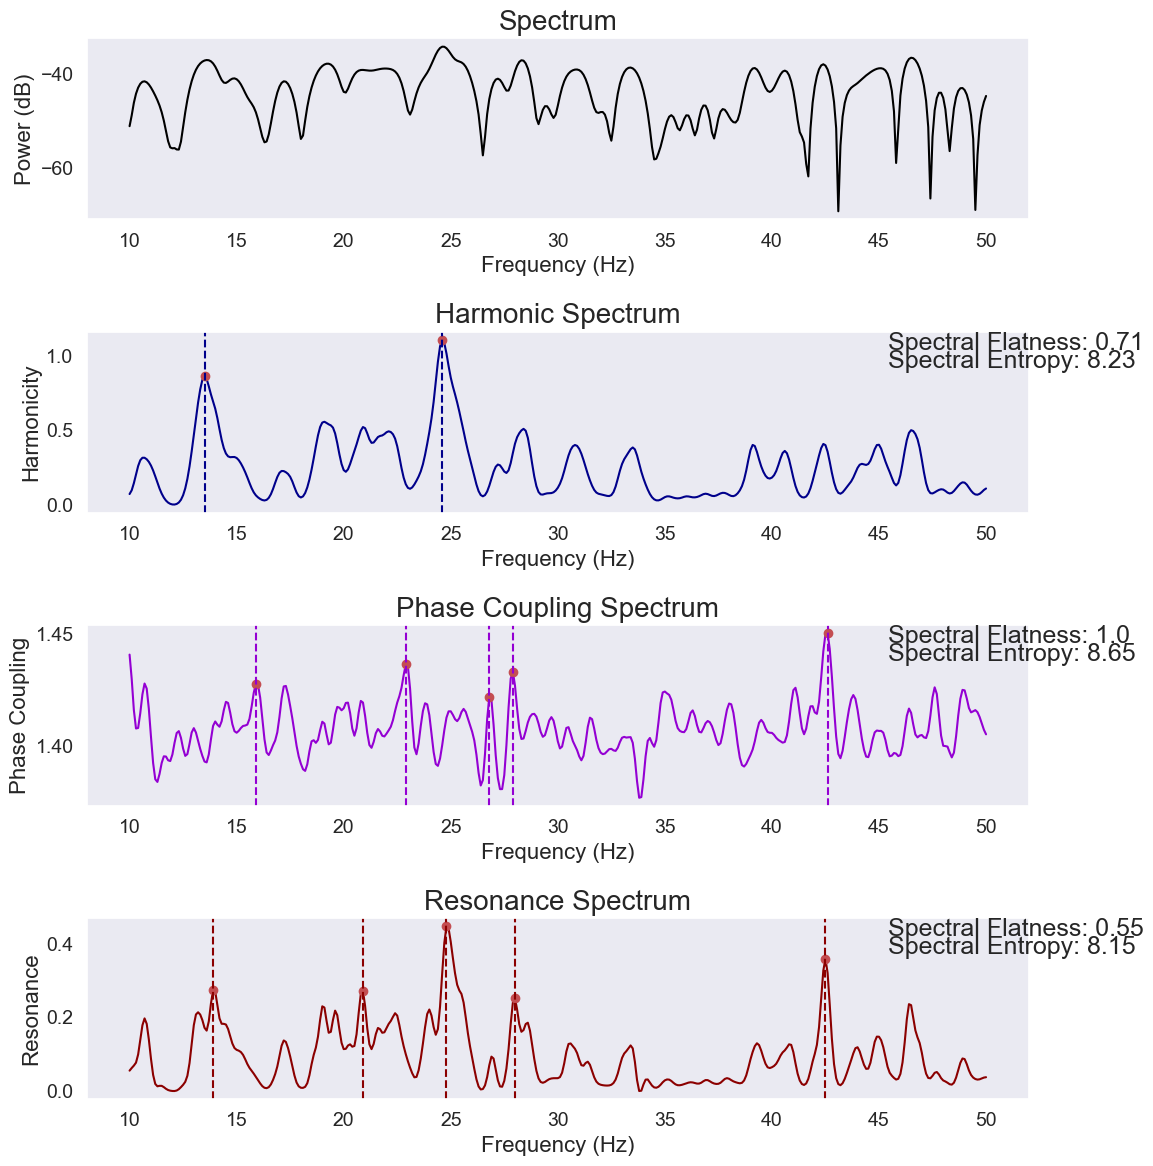

In [22]:
from biotuner.harmonic_spectrum import compute_global_harmonicity
import numpy as np
# clear plot
plt.clf()
# generate a signal with peaks at 10, 20 and 30 Hz
time = np.linspace(0, 1, 2000)
signal = np.sum([1 * np.sin(2 * np.pi * freq * time) for freq in [10, 20, 30]], axis=0)
# add 10% of noise
signal += np.random.normal(0, 0.2, len(time))

# generate a white noise signal
pink_noise = np.random.normal(0, 0.2, len(time))

harm_spectrum_df = compute_global_harmonicity(pink_noise, 0.1, 10, 50, fs=1000,
                                             noverlap=1, power_law_remove=True, n_peaks=5, plot=True,
                                             smoothness=1, metric='harmsim', delta_lim=500, smoothness_harm=2, 
                                             n_harms=5, phase_mode=None)